In [102]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
api_key = 'XXXX'

In [3]:
channel_ids = ['UCd9TUql8V7J-Xy1RNgA7MlQ',
            # add more channels if needed
            ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [5]:
def get_channel_stats(youtube, channel_ids):

    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {
            'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }

        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,zanny,2190000,553396676,581,UUd9TUql8V7J-Xy1RNgA7MlQ


In [124]:
playlist_id = channel_stats['playlistId']
print(playlist_id)

0    UUd9TUql8V7J-Xy1RNgA7MlQ
Name: playlistId, dtype: object


In [9]:
playlist_id = 'UUd9TUql8V7J-Xy1RNgA7MlQ'
#playlist_id = channel_stats['playlistId']

def get_video_ids(youtube, playlist_id):

    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    # gets the other video ids
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids


In [10]:
video_ids = get_video_ids(youtube, playlist_id)

In [11]:
len(video_ids)

581

In [12]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']
        
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [13]:
video_df = get_video_details(youtube, video_ids)

In [14]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,sRlZZxPfiVg,zanny,What if I told you Fortnite is good now,my new character arc\n\n0:00 Intro\n2:49 Part ...,None,2023-07-06T22:30:06Z,818275,51688,None,1638,PT14M9S,hd,false
1,SvQCWs9GAGY,zanny,POV: You've gone insane deep in Subnautica Bel...,Download Ever Legion for free right now: https...,None,2023-06-23T21:00:30Z,864041,56854,None,2639,PT16M3S,hd,false
2,MCh16bVeBPs,zanny,The end of Jedi Survivor got me messed up,ready for part 3\n\n\n►zan clan meme merch\nht...,None,2023-06-10T20:00:06Z,1206026,62757,None,2525,PT20M37S,hd,false
3,vWVf7NcV6to,zanny,Look what has become of Fortnite,if you're reading this it means I've already c...,None,2023-05-31T17:30:06Z,1314566,63771,None,1940,PT12M6S,hd,false
4,mO3Ary5Ubz0,zanny,I've been violating the Geneva Convention in J...,does the sword count as cheating?\n\n\n►zan cl...,None,2023-05-17T20:15:01Z,1524417,78104,None,3131,PT20M2S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,_MlL7C-sxY0,zanny,Luck or skill?,You decide.\n\nI'm gonna go out on a limb here...,None,2013-08-04T05:46:30Z,9297,246,None,34,PT26S,hd,false
577,Ut-iJ2vCg6Q,zanny,The laggiest Halo 4 game ever,Absolutely ridiculous.,"[halo4, lag, funny, halo, Xbox]",2013-06-29T06:25:33Z,11803,314,None,39,PT4M38S,sd,false
578,B9Hmyq-okEM,zanny,Right in the ass,The funniest assassination I've ever got in Ha...,"[halo4, funny, assassination, Xbox, ouch, ass,...",2013-06-29T05:21:31Z,19673,821,None,34,PT29S,hd,false
579,J3M0_XCBXXY,zanny,Halo 4 Untouchable+Perfection Gameplay,A perfection I got in Infinity Slayer on Haven...,None,2013-05-08T21:22:29Z,12405,379,None,31,PT6M54S,hd,false


In [15]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [18]:
vid_comments = get_comments_in_videos(youtube, video_ids)

In [20]:
vid_comments

,video_id,comments
0,sRlZZxPfiVg,[this was edited by past zanny 🙏\n\nalso grab ...
1,SvQCWs9GAGY,[Download Ever Legion for free right now: http...
2,MCh16bVeBPs,"[hope you guys like it\n🎉 ENJOY 🎉, Cross guar..."
3,vWVf7NcV6to,[come and climb Mount Funny\nhttps://crowdmade...
4,mO3Ary5Ubz0,[welcome to Mount Funny\nhttps://crowdmade.com...
...,...,...
576,_MlL7C-sxY0,[Zany Log 5: So his halo skills exsited all th...
577,Ut-iJ2vCg6Q,[Zany Log 4: Ah so the intro stays. well the h...
578,B9Hmyq-okEM,[Zany Log 3: It seems sun tzu's boi had a grow...
579,J3M0_XCBXXY,"[Hello Zandril, Zanny Log 2: This time zanny s..."


## Data Pre-Processing

In [19]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [106]:
# Check for data types
video_df.dtypes

video_id                               object
channelTitle                           object
title                                  object
description                            object
tags                                   object
publishedAt           datetime64[ns, tzutc()]
viewCount                             float64
likeCount                             float64
favouriteCount                        float64
commentCount                          float64
duration                               object
definition                             object
caption                                object
pushblishDayName                       object
durationSecs                          float64
tagCount                                int64
title_no_stopwords                     object
dtype: object

In [29]:
# convert count columns to numeric
numeric_cols = ['viewCount','likeCount','favouriteCount','commentCount']
video_df[numeric_cols]= video_df[numeric_cols].apply(pd.to_numeric, axis = 1, errors = 'coerce')

In [37]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [39]:
#convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [42]:
video_df[['durationSecs','duration']]

,durationSecs,duration
0,849.0,PT14M9S
1,963.0,PT16M3S
2,1237.0,PT20M37S
3,726.0,PT12M6S
4,1202.0,PT20M2S
...,...,...
576,26.0,PT26S
577,278.0,PT4M38S
578,29.0,PT29S
579,414.0,PT6M54S


In [45]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [46]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,sRlZZxPfiVg,zanny,What if I told you Fortnite is good now,my new character arc\n\n0:00 Intro\n2:49 Part ...,None,2023-07-06 22:30:06+00:00,818275.0,51688.0,NaN,1638.0,PT14M9S,hd,false,Thursday,849.0,0
1,SvQCWs9GAGY,zanny,POV: You've gone insane deep in Subnautica Bel...,Download Ever Legion for free right now: https...,None,2023-06-23 21:00:30+00:00,864041.0,56854.0,NaN,2639.0,PT16M3S,hd,false,Friday,963.0,0
2,MCh16bVeBPs,zanny,The end of Jedi Survivor got me messed up,ready for part 3\n\n\n►zan clan meme merch\nht...,None,2023-06-10 20:00:06+00:00,1206026.0,62757.0,NaN,2525.0,PT20M37S,hd,false,Saturday,1237.0,0
3,vWVf7NcV6to,zanny,Look what has become of Fortnite,if you're reading this it means I've already c...,None,2023-05-31 17:30:06+00:00,1314566.0,63771.0,NaN,1940.0,PT12M6S,hd,false,Wednesday,726.0,0
4,mO3Ary5Ubz0,zanny,I've been violating the Geneva Convention in J...,does the sword count as cheating?\n\n\n►zan cl...,None,2023-05-17 20:15:01+00:00,1524417.0,78104.0,NaN,3131.0,PT20M2S,hd,false,Wednesday,1202.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,_MlL7C-sxY0,zanny,Luck or skill?,You decide.\n\nI'm gonna go out on a limb here...,None,2013-08-04 05:46:30+00:00,9297.0,246.0,NaN,34.0,PT26S,hd,false,Sunday,26.0,0
577,Ut-iJ2vCg6Q,zanny,The laggiest Halo 4 game ever,Absolutely ridiculous.,"[halo4, lag, funny, halo, Xbox]",2013-06-29 06:25:33+00:00,11803.0,314.0,NaN,39.0,PT4M38S,sd,false,Saturday,278.0,5
578,B9Hmyq-okEM,zanny,Right in the ass,The funniest assassination I've ever got in Ha...,"[halo4, funny, assassination, Xbox, ouch, ass,...",2013-06-29 05:21:31+00:00,19673.0,821.0,NaN,34.0,PT29S,hd,false,Saturday,29.0,7
579,J3M0_XCBXXY,zanny,Halo 4 Untouchable+Perfection Gameplay,A perfection I got in Infinity Slayer on Haven...,None,2013-05-08 21:22:29+00:00,12405.0,379.0,NaN,31.0,PT6M54S,hd,false,Wednesday,414.0,0


# EDA

## Best performing videos

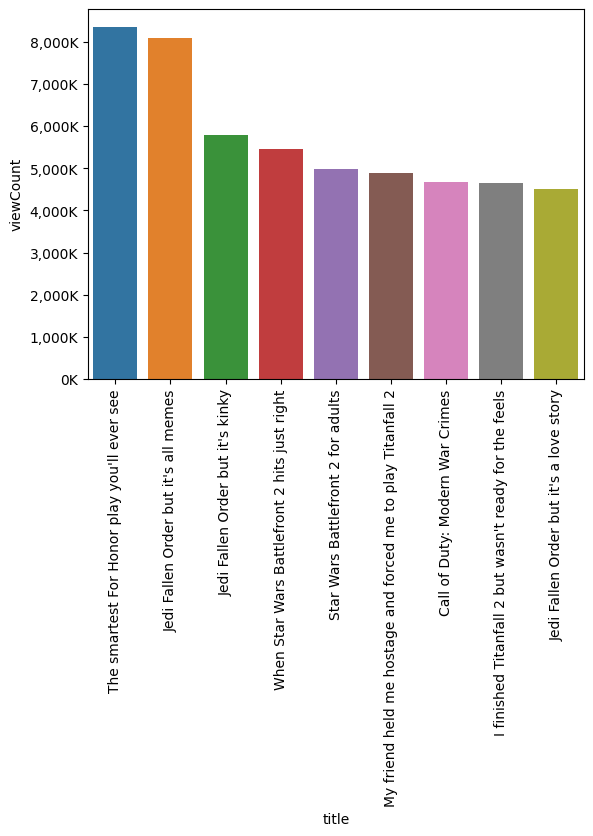

In [77]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False)[0:9])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

## Worst Performing Videos

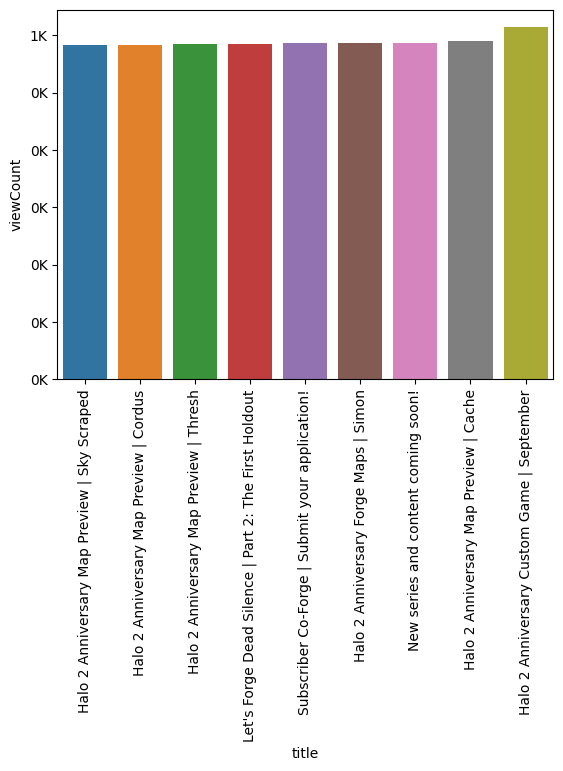

In [78]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = True)[0:9])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

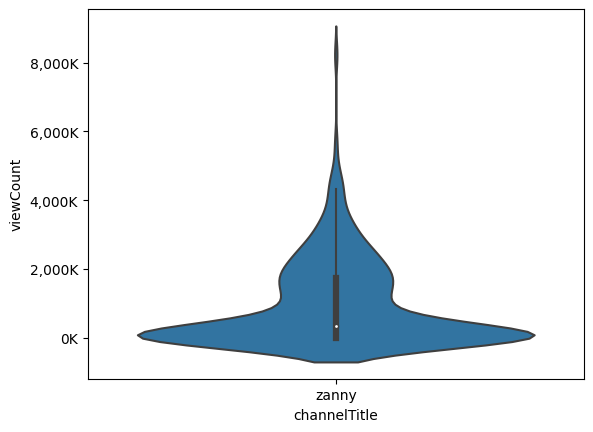

In [89]:
ax = sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

## Views vs likes and comments

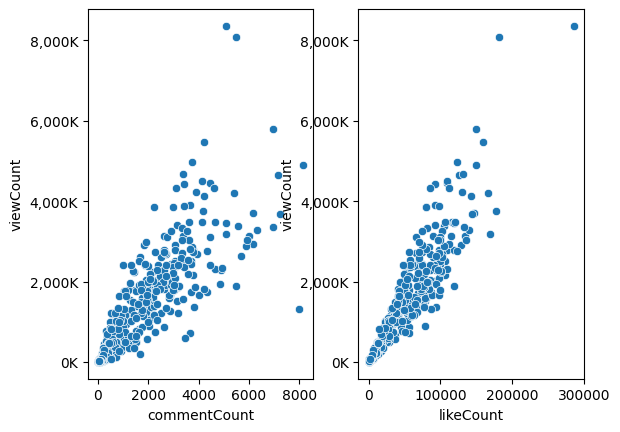

In [93]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x ='commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x ='likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

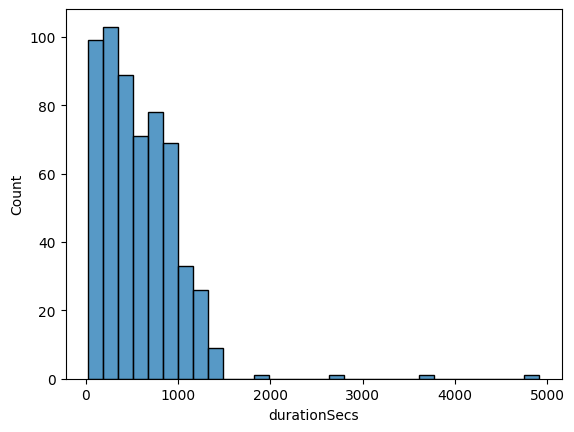

In [97]:
sns.histplot(data = video_df, x = 'durationSecs', bins = 30)

## Wordcloud for video titles

In [ ]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule

[Text(0, 0, 'Sunday'),
 Text(1, 0, 'Monday'),
 Text(2, 0, 'Tuesday'),
 Text(3, 0, 'Wednesday'),
 Text(4, 0, 'Thursday'),
 Text(5, 0, 'Friday'),
 Text(6, 0, 'Saturday')]

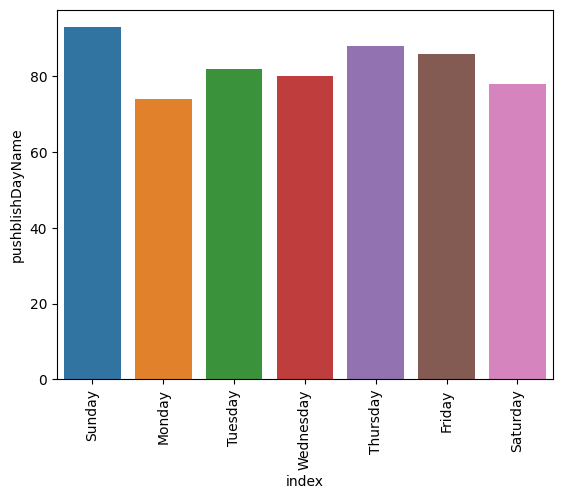

In [121]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_df = day_df.reindex(weekdays)
ax = sns.barplot(data = day_df.reset_index(), x = 'index', y = 'pushblishDayName')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [116]:
day_df

,pushblishDayName
Sunday,93
Monday,74
Tuesday,82
Wednesday,80
Thursday,88
Friday,86
Saturday,78
